In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import glob
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets
from torchinfo import summary

#乱数固定用の処理
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(123)
torch.cuda.manual_seed(123)

c:\Users\ohno\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
#データ読み込み
df = pd.read_csv("/Users/ohno/study/data/price.csv")
df = df.drop(columns=['Unnamed: 0'])
# df['Label'] = df['Close']/df['Close'].shift(1)
# df['Label'] = (df['Label'] >= 1)*1
# df = df.dropna()
# df = df.reset_index(drop=True)
# # print(df.index[df["Date"] == '2020/11/25'].item())
df

,Date,Open,High,Low,Close,MACD,Signal,RSI,SMA5,SMA25,Label
0,2001/3/2,12594.46,12594.46,12261.80,12261.80,-213.857818,-137.958324,18.943629,12817.600,13288.5676,0
1,2001/3/5,12285.46,12389.09,12133.90,12322.16,-246.420657,-152.460470,23.265187,12641.804,13233.6116,1
2,2001/3/6,12402.89,12687.74,12351.14,12687.74,-241.066496,-165.508645,36.052169,12567.380,13187.3100,1
3,2001/3/7,12748.56,12824.19,12539.75,12723.89,-231.332099,-176.742605,35.836658,12535.450,13143.1996,1
4,2001/3/8,12694.22,12756.97,12584.10,12650.56,-226.711810,-188.485704,37.208872,12529.230,13095.4800,0
...,...,...,...,...,...,...,...,...,...,...,...
4956,2021/4/14,29718.06,29722.40,29567.18,29620.99,109.455309,106.458295,65.115498,29677.674,29526.6704,0
4957,2021/4/15,29573.90,29787.66,29558.55,29642.69,103.346146,113.052751,59.236487,29664.416,29543.9124,1
4958,2021/4/16,29789.08,29789.08,29621.83,29683.37,100.627160,113.333455,56.343906,29647.478,29542.5340,1
4959,2021/4/19,29688.32,29808.01,29530.84,29685.37,97.509696,112.162026,55.470871,29676.806,29539.2700,1


In [3]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, labels_list, image_transform=None, transform=None):
        self.file_list = file_list
        self.labels_list = labels_list
        self.image_transform = image_transform
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        labels = self.labels_list[idx]

        img = Image.open(img_path).convert('RGB')
        labels =  labels.reshape(1, -1)

        images = self.image_transform(img)
        labels = self.transform(labels)

        return images, labels.squeeze()

In [4]:
class MyTransforms:
    def __init__(self) -> None:
        pass

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # x = x.to(torch.float32)
        x = x.to(torch.int64)
        return x

{'down': 0, 'up': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image size: torch.Size([32, 3, 224, 224])
label size: torch.Size([32])

torch.int64


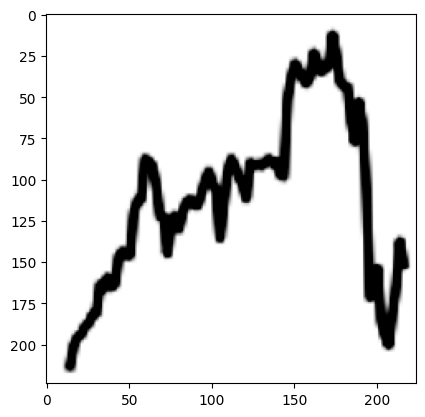

In [5]:
train_image_dir = '/Users/ohno/study/images/Close/90days/train/'
val_image_dir = '/Users/ohno/study/images/Close/90days/val/'

data_transform = {
    'train': transforms.Compose([
        # transforms.Grayscale(num_output_channels=1),
        transforms.CenterCrop(100),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ]),
    'val': transforms.Compose([
        # transforms.Grayscale(num_output_channels=1),
        transforms.CenterCrop(100),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ])
}

train_dataset = torchvision.datasets.ImageFolder(root=train_image_dir, transform=data_transform['train'])
val_dataset = torchvision.datasets.ImageFolder(root=val_image_dir, transform=data_transform['val'])

print(train_dataset.class_to_idx)

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)
for images, labels in train_loader:
    break
img = images[0].permute(1,2,0)
plt.imshow(img, cmap='gray')
print(f"image size: {images.shape}")
print(f"label size: {labels.shape}\n")
print(labels.dtype)

In [6]:
# num_data = df.shape[0]
# date_span = 60
# train_len = df.index[df["Date"] == '2020/11/25'].item()
# labels_list = []
# # print(train_len)

# train_dir = 'C:/Users/ohno/study/images/RSI'

# train_orig_list = glob.glob(os.path.join(train_dir,'*.png'))
# for i in range(len(train_orig_list)):
#     labels_list.append(df.loc[i+date_span, 'Label'])
# labels_list = np.array(labels_list)
# # print(len(train_orig_list))
# # print(labels_list[0].shape)

# train_list, test_list = train_test_split(train_orig_list, train_size = train_len, shuffle=False)
# train_labels, test_labels = train_test_split(labels_list, train_size = train_len, shuffle=False)

# print(f"train_list size: {len(train_list)}")
# print(f"train_labels size: {train_labels.shape}\n")
# print(f"test_list size: {len(test_list)}")
# print(f"test_labels size: {test_labels.shape}")

In [7]:
# transform = transforms.Compose([
#         transforms.ToTensor(),
#         MyTransforms()
#         ])

# image_transform = transforms.Compose([
#         transforms.Grayscale(num_output_channels=1),
#         transforms.CenterCrop(100),
#         # transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(0.5, 0.5),
#         ])

# train_dataset = ImageDataset(train_list, train_labels, image_transform=image_transform, transform=transform)
# val_dataset = ImageDataset(test_list, test_labels, image_transform=image_transform, transform=transform)

# batch_size = 32
# train_loader = torch.utils.data.DataLoader(
#     train_dataset, batch_size=batch_size, shuffle=True
# )
# val_loader = torch.utils.data.DataLoader(
#     val_dataset, batch_size=batch_size, shuffle=False
# )

# for images, labels in train_loader:
#     img = images[0].permute(1,2,0)
#     plt.imshow(img, cmap='gray')
#     break
# # labels = labels.unsqueeze(-1)
# print(f"images size: {images.shape}")
# print(f"labels size: {labels.shape}")
# print(labels.dtype)

In [8]:
sequence_size = 2
batch_size = 32
img_size = 224
hidden_size = 128
a = torch.zeros((300, 224, 224))
# print(a[0].shape)

conv1 = nn.Conv2d(300, 150, 5)
conv2 = nn.Conv2d(150, 30, 5)
relu = nn.ReLU(inplace=True)
maxpool = nn.MaxPool2d((2,2))
flatten = nn.Flatten()

cnn = nn.Sequential(
        conv1,
        relu,
        maxpool,
        conv2,
        relu,
        maxpool,
        flatten,
)

x = cnn(a)
print(x.shape)

torch.Size([30, 2809])


In [9]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 5, 5)
    self.conv2 = nn.Conv2d(5, 10, 5)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(10 * 53 * 53, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)
    self.softmax = nn.Softmax(dim=1)
    self.sigmoid = nn.Sigmoid()
    self.dropout = nn.Dropout(0.2)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.maxpool,
        self.conv2,
        self.relu,
        self.maxpool,
        self.dropout,
    )
    
    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.dropout,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3

In [10]:
net = CNN(n_output = 2, n_hidden = 128).to(device)
summary(net)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Conv2d: 1-1                            380
├─Conv2d: 1-2                            1,260
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Flatten: 1-5                           --
├─Linear: 1-6                            3,595,648
├─Linear: 1-7                            258
├─Softmax: 1-8                           --
├─Sigmoid: 1-9                           --
├─Dropout: 1-10                          --
├─Sequential: 1-11                       1,640
│    └─Conv2d: 2-1                       (recursive)
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       (recursive)
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Dropout: 2-7                      --
├─Sequential: 1-12                       3,595,906
│    └─Linear: 2-8             

In [11]:
def train():
    epochs = 100
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(epochs+1):
        net.train()
        train_loss = 0
        train_acc = 0
        total = 0
        for j, (inputs, labels) in enumerate(train_loader):
            total += len(labels)
            # labels = labels.unsqueeze(-1)
            # labels = labels.to(torch.float64)
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            predicted = torch.max(outputs, 1)[1]
            # predicted = torch.where(outputs < 0.5, 0, 1)
            train_loss += loss.item()
            train_acc += (predicted == labels).sum().item()
        train_loss /= j+1
        train_acc /= total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        scheduler.step()
        
        net.eval()
        with torch.no_grad():
            val_loss = 0
            val_acc = 0
            total = 0
            for j, (inputs, labels) in enumerate(val_loader):
                total += len(labels)
                # labels = labels.unsqueeze(-1)
                # labels = labels.to(torch.float64)

                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                predicted = torch.max(outputs, 1)[1]
                # predicted = torch.where(outputs < 0.5, 0, 1)
                val_loss += loss.item()
                val_acc += (predicted == labels).sum().item()
            val_loss /= j+1
            val_acc /= total
            val_loss_history.append(val_loss)
            val_acc_history.append(val_acc)
        # my_lr = scheduler.get_lr()
        # print(print(my_lr))
        print(f"Epoch: {epoch+1}, train_loss: {train_loss}, train_acc: {train_acc}, val_loss: {val_loss}, val_acc: {val_acc}")
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history 

In [12]:
def test():
    net.eval()
    with torch.no_grad():
        test_acc = 0
        count = 0
        for images, labels in val_loader:
            count += len(labels)
            # labels = labels.unsqueeze(-1)
            # labels = labels.to(torch.float64)

            images = images.to(device)
            outputs = net(images)
            outputs = outputs.to('cpu')
            predicted = torch.max(outputs, 1)[1]
            # predicted = torch.where(outputs < 0.5, 0, 1)
            test_acc += (predicted == labels).sum().item()
        ave_test_acc = test_acc / count

    return ave_test_acc

Epoch: 1, train_loss: 0.6929019322072653, train_acc: 0.518676122931442, val_loss: 0.6910785809159279, val_acc: 0.5224489795918368
Epoch: 2, train_loss: 0.69166772616537, train_acc: 0.5193853427895981, val_loss: 0.688925489783287, val_acc: 0.5224489795918368
Epoch: 3, train_loss: 0.6915539485171325, train_acc: 0.5293144208037825, val_loss: 0.6928412839770317, val_acc: 0.5102040816326531
Epoch: 4, train_loss: 0.6895459043352228, train_acc: 0.5446808510638298, val_loss: 0.6887010931968689, val_acc: 0.5265306122448979
Epoch: 5, train_loss: 0.6878285161534646, train_acc: 0.5385342789598109, val_loss: 0.6889826506376266, val_acc: 0.5428571428571428
Epoch: 6, train_loss: 0.6857077241840219, train_acc: 0.5539007092198581, val_loss: 0.6890299245715141, val_acc: 0.5673469387755102
Epoch: 7, train_loss: 0.682526633703619, train_acc: 0.5687943262411348, val_loss: 0.6855020001530647, val_acc: 0.5551020408163265
Epoch: 8, train_loss: 0.6782644068388114, train_acc: 0.5867612293144208, val_loss: 0.681

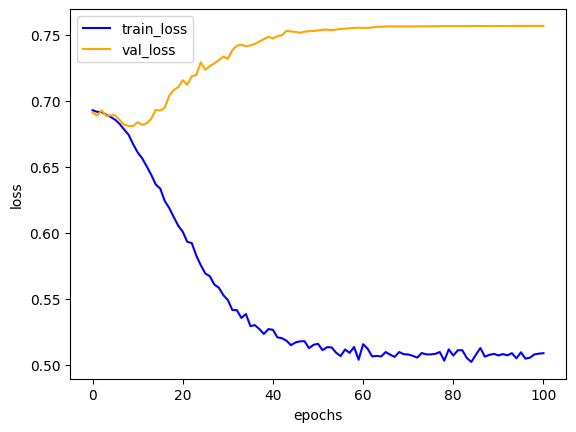

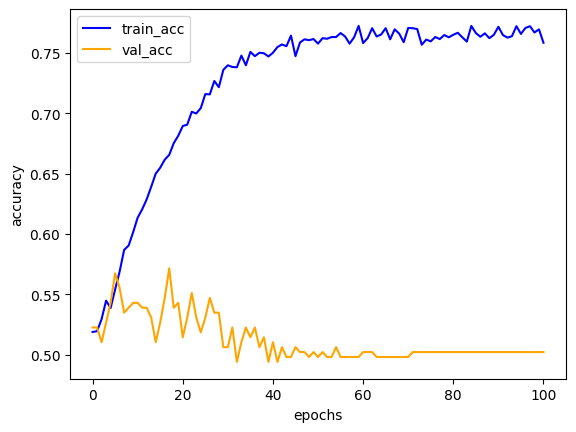

In [13]:
total_train_loss_history = []
total_train_acc_history = []
total_val_loss_history = []
total_val_acc_history = []
total_test_acc = []

for i in range(1):
    net = CNN(n_output = 2, n_hidden = 128).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    tlh, tah, vlh, vah = train()
    tmp_test_acc = test()
    total_train_loss_history.append(tlh)
    total_train_acc_history.append(tah)
    total_val_loss_history.append(vlh)
    total_val_acc_history.append(vah)
    total_test_acc.append(tmp_test_acc)

train_loss_history = np.mean(np.array(total_train_loss_history), axis=0)
train_acc_history = np.mean(np.array(total_train_acc_history), axis=0)
val_loss_history = np.mean(np.array(total_val_loss_history), axis=0)
val_acc_history = np.mean(np.array(total_val_acc_history), axis=0)
test_acc = np.mean(np.array(total_test_acc), axis=0)

plt.plot(range(len(train_loss_history)), train_loss_history, label='train_loss', color='blue')
plt.plot(range(len(val_loss_history)), val_loss_history, label='val_loss', color='orange')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.plot(range(len(train_acc_history)), train_acc_history, label='train_acc', color='blue')
plt.plot(range(len(val_acc_history)), val_acc_history, label='val_acc', color='orange')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

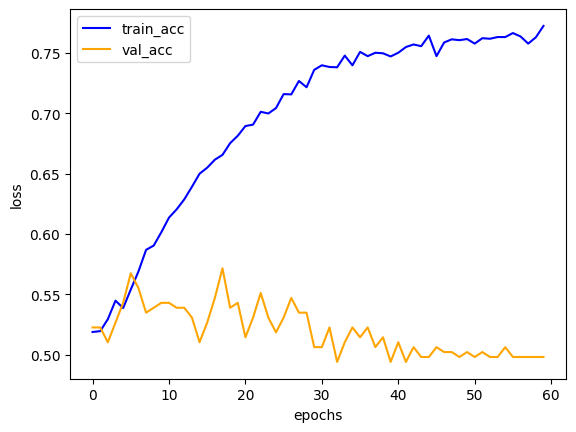

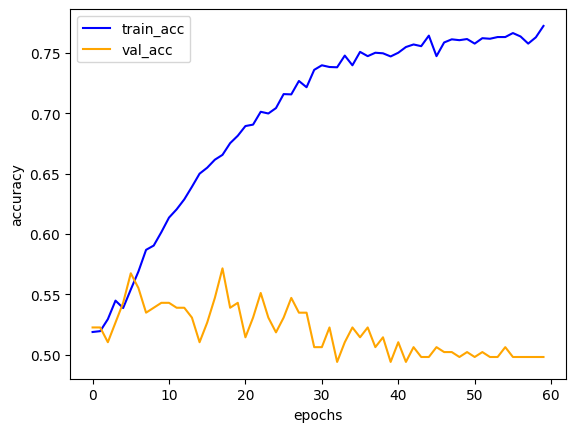

0.5020408163265306


In [14]:
plt.plot(range(60), total_train_acc_history[0][:60], label='train_acc', color='blue')
plt.plot(range(60), total_val_acc_history[0][:60], label='val_acc', color='orange')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.plot(range(60), train_acc_history[:60], label='train_acc', color='blue')
plt.plot(range(60), val_acc_history[:60], label='val_acc', color='orange')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

print(test_acc)